In [5]:
from keras.datasets import imdb
import pandas as pd
import numpy as np
from keras.layers import LSTM, Activation, Dropout, Dense, Input
#from keras.layers.embeddings import Embedding
from keras.models import Model
import string
import re
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelBinarizer
#from keras.preprocessing.sequence import pad_sequences
import keras
from sklearn.model_selection import train_test_split

In [2]:
pip install keras-pos-embd

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [49]:
train = pd.read_csv("C:/Users/USER/Downloads/CleanDatasetMedical.csv")
test = pd.read_csv("C:/Users/USER/Downloads/df_test_sentiment.csv")

In [50]:
train=train.dropna()

In [51]:
train = train.reset_index()

In [52]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161291 entries, 0 to 161290
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   index            161291 non-null  int64 
 1   Unnamed: 0       161291 non-null  int64 
 2   Lemmatized_text  161291 non-null  object
 3   comp_score       161291 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 4.9+ MB
None


In [10]:
train['Lemmatized_text'] = train['Lemmatized_text'].str.lower()

In [11]:
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", 
             "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during",
             "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", 
             "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into",
             "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or",
             "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", 
             "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's",
             "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up",
             "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's",
             "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've",
             "your", "yours", "yourself", "yourselves" ]

In [13]:
def remove_stopwords(data):
  train['review without stopwords'] = train['Lemmatized_text'].apply(lambda x : ' '.join([word for word in x.split() if word not in (stopwords)]))
  return data

def remove_tags(string):
    result = re.sub('<.*?>','',string)
    return result
    
data_without_stopwords = remove_stopwords(train)
data_without_stopwords['clean_review']= data_without_stopwords['review without stopwords'].apply(lambda cw : remove_tags(cw))
data_without_stopwords['clean_review'] = data_without_stopwords['clean_review'].str.replace('[{}]'.format(string.punctuation), ' ')

C:\Users\USER\AppData\Local\Temp\ipykernel_15240\4002884222.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  data_without_stopwords['clean_review'] = data_without_stopwords['clean_review'].str.replace('[{}]'.format(string.punctuation), ' ')


In [17]:
data_without_stopwords

,index,Unnamed: 0,Lemmatized_text,comp_score,review without stopwords,clean_review
0,0,0,side effect take combination bystolic mg fish oil,1,side effect take combination bystolic mg fish oil,side effect take combination bystolic mg fish oil
1,1,1,son halfway fourth week intuniv became concern...,1,son halfway fourth week intuniv became concern...,son halfway fourth week intuniv became concern...
2,2,2,used take another oral contraceptive pill cycl...,1,used take another oral contraceptive pill cycl...,used take another oral contraceptive pill cycl...
3,3,3,first time using form birth control glad went ...,1,first time using form birth control glad went ...,first time using form birth control glad went ...
4,4,4,suboxone completely turned life around feel he...,1,suboxone completely turned life around feel he...,suboxone completely turned life around feel he...
...,...,...,...,...,...,...
161286,161292,161292,wrote first report mid october alcohol since p...,1,wrote first report mid october alcohol since p...,wrote first report mid october alcohol since p...
161287,161293,161293,given iv surgey immediately became anxious cou...,0,given iv surgey immediately became anxious sit...,given iv surgey immediately became anxious sit...
161288,161294,161294,limited improvement month developed bad rash m...,0,limited improvement month developed bad rash m...,limited improvement month developed bad rash m...
161289,161295,161295,thyroid medication year spent first synthroid ...,1,thyroid medication year spent first synthroid ...,thyroid medication year spent first synthroid ...


In [20]:
X_train, X_test,Y_train, Y_test = train_test_split(train['Lemmatized_text'], train['comp_score'], test_size=0.2, random_state = 45)

In [21]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

words_to_index = tokenizer.word_index

In [22]:
def read_glove_vector(glove_vec):
  with open(glove_vec, 'r', encoding='UTF-8') as f:
    words = set()
    word_to_vec_map = {}
    for line in f:
      w_line = line.split()
      curr_word = w_line[0]
      word_to_vec_map[curr_word] = np.array(w_line[1:], dtype=np.float64)



  return word_to_vec_map

In [23]:
word_to_vec_map = read_glove_vector('C:/Users/USER/Downloads/glove.6B.50d.txt/glove.6B.50d.txt')

maxLen = 150

In [36]:
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
#stop=set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import gensim
import string
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l1
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score 
import numpy as np
from time import time
import os

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_curve

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
lemma = WordNetLemmatizer()

from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Bidirectional, LSTM, Dropout, BatchNormalization
#from keras.layers.embeddings import Embedding

In [44]:
from keras_preprocessing.sequence import pad_sequences

In [47]:
embeddings_index = dict()
f = open('C:/Users/USER/Downloads/glove.6B.50d.txt/glove.6B.50d.txt',encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [56]:
max_length = train.Lemmatized_text.apply(lambda x: len(x.split())).max()

t = Tokenizer()
t.fit_on_texts(train.Lemmatized_text)
vocab_size = len(t.word_index) + 1
encoded_tweets = t.texts_to_sequences(train.Lemmatized_text)
padded_tweets = pad_sequences(encoded_tweets, maxlen=max_length, padding='post')

vocab_size = len(t.word_index) + 1

In [57]:
embedding_matrix = np.zeros((vocab_size, 50))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [58]:
x_train, x_test, y_train, y_test = train_test_split(padded_tweets, train.comp_score, test_size=0.2, stratify=train.comp_score)

In [59]:
model_glove = Sequential()
model_glove.add(Embedding(vocab_size, 50, input_length=max_length, weights=[embedding_matrix], trainable=True))
model_glove.add(Bidirectional(LSTM(20, return_sequences=True)))
model_glove.add(Dropout(0.2))
model_glove.add(BatchNormalization())
model_glove.add(Bidirectional(LSTM(20, return_sequences=True)))
model_glove.add(Dropout(0.2))
model_glove.add(BatchNormalization())
model_glove.add(Bidirectional(LSTM(20)))
model_glove.add(Dropout(0.2))
model_glove.add(BatchNormalization())
model_glove.add(Dense(64, activation='relu'))
model_glove.add(Dense(64, activation='relu'))
model_glove.add(Dense(1, activation='sigmoid'))
model_glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [60]:
## Fit train data
model_glove.fit(x_train, y_train, epochs = 10)

Epoch 1/10
4033/4033 [==============================] - 55916s 14s/step - loss: 0.3739 - accuracy: 0.8253
Epoch 2/10
4033/4033 [==============================] - 26821s 7s/step - loss: 0.1948 - accuracy: 0.9246
Epoch 3/10
4033/4033 [==============================] - 57425s 14s/step - loss: 0.1330 - accuracy: 0.9500
Epoch 4/10
4033/4033 [==============================] - 28157s 7s/step - loss: 0.0986 - accuracy: 0.9635
Epoch 5/10
4033/4033 [==============================] - 52540s 13s/step - loss: 0.0727 - accuracy: 0.9735
Epoch 6/10
4033/4033 [==============================] - 34756s 9s/step - loss: 0.0588 - accuracy: 0.9788
Epoch 7/10
4033/4033 [==============================] - 83364s 21s/step - loss: 0.0461 - accuracy: 0.9836
Epoch 8/10
4033/4033 [==============================] - 8247s 2s/step - loss: 0.0378 - accuracy: 0.9865
Epoch 9/10
4033/4033 [==============================] - 132366s 33s/step - loss: 0.0330 - accuracy: 0.9885
Epoch 10/10
4033/4033 [===========================

In [61]:


y_pred = model_glove.predict(x_test)



1009/1009 [==============================] - 456s 437ms/step


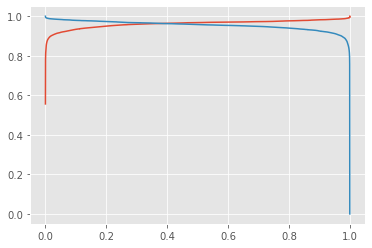

Crossover at 0.38 with recall 0.96
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     15546
           1       0.96      0.96      0.96     16713

    accuracy                           0.96     32259
   macro avg       0.96      0.96      0.96     32259
weighted avg       0.96      0.96      0.96     32259



In [62]:
pr, rc, thresholds = precision_recall_curve(y_test, y_pred)
plt.plot(thresholds, pr[1:])
plt.plot(thresholds, rc[1:])
plt.show()
crossover_index = np.max(np.where(pr == rc))
crossover_cutoff = thresholds[crossover_index]
crossover_recall = rc[crossover_index]
print("Crossover at {0:.2f} with recall {1:.2f}".format(crossover_cutoff, crossover_recall))
print(classification_report(y_test, y_pred > crossover_cutoff))